# CS 109A/AC 209A/STAT 121A Data Science: Midterm 2
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Tuesday, November 22nd, 2016 at 12:00pm

In [404]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix
import csv
from sklearn.svm import SVC
from sklearn import svm
from sklearn.cross_validation import train_test_split
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Part I: Diagnosing the Semian Flu 2016

You are given the early data for an outbreak of a dangerous virus originating from a group of primates being keeped in a Massechussetts biomedical research lab, this virus is dubbed the "Semian Flu".

You have the medical records of $n$ number of patients in `'flu_train.csv`. There are two general types of patients in the data, flu patients and healthy (this is recorded in the column labeled `flu`, a 0 indicates the absences of the virus and a 1 indicates presence). Furthermore, scientists have found that there are two strains of the virus, each requiring a different type of treatment (this is recorded in the column labeled `flutype`, a 1 indicates the absences of the virus, a 2 indicates presence of strain 1 and a 3 indicates the presence of strain 2).

**Your task:** build a model to predict if a given patient has the flu. Your goal is to catch as many flu patients as possible without misdiagnosing too many healthy patients.

**The deliverable:** a function called `flu_predict` which satisfies:

- input: `x_test`, a set of medical predictors for a group of patients
- output: `y_pred`, a set of labels, one for each patient; 0 for healthy and 1 for infected with the flu virus

The MA state government will use your model to diagnose sets of future patients (held by us). You can expect that there will be an increase in the number of flu patients in any groups of patients in the future.

We provide you with some benchmarks for comparison.

**Baseline Model:** 
- ~50% expected accuracy on healthy patients in observed data
- ~50% expected accuracy on flu patients in observed data
- ~50% expected accuracy on healthy patients in future data 
- ~50% expected accuracy on flu patients in future data
- time to build: 5 min

**Reasonable Model:** 
- ~69% expected accuracy on healthy patients in observed data
- ~55% expected accuracy on flu patients, in observed data
- ~69% expected accuracy on healthy patients in future data
- ~60% expected accuracy on flu patients, in future data
- time to build: 20 min

**Grading:**
Your grade will be based on:
1. your model's ability to out-perform our benchmarks
2. your ability to carefully and thoroughly follow the data science pipeline (see lecture slides for definition)
3. the extend to which all choices are reasonable and defensible by methods you have learned in this class

---

The first step is to clean the dataset. I accomplished this through a series of steps after uploading the csvs.
1. I made sure all types were either float64 or object. This was accomplished by iterating and finding all columns with type int64 and using .astype to alter them as floats. 
2. Next, I made sure all object types were categorical. This was correct so I did not have to manually change more to type float64.
3. I noticed that race3 and race1 were very similiar except race1 did not include asians but rather labeled them as other. I combined columns race1 and race3 but encoding asians in race1. This was accomplished by creating a for loop and for every instance of asian in race3, I altered the corresponding race1 cell.  
4. Next I dropped columns with duplicate information. There are 3 columns for age and 2 for income so I dropped the excess information. ID is also not informative in predicting disease (no correlation) so I dropped it as well.
5. There are a lot of entries with NaN because no value is entered. I dropped columns with more than 50% NaNs because there is not enough data to get a fair estimate through imputation. 
6. With the remaining columns, I replaced all NaNs for categorical columns with the mode (most frequent entry) and I replaced all NaNs for quantitative columns with the median. 
7. Lastly, I one hot the categorical variables to be able to start testing my models. 

I created a random model that randomly predicts 0 or 1. This gives me a correct classification accuracy of ~50% for both class 0 and class 1. 

I then tuned a few parameters for decision trees and KNN to establish a quick tuning baseline. I then tested 10 different models:
1. KNN
2. Unweighted logistic regression
3. Unweighted logistic quadratic regression
4. Weighted logistic regression
5. Weighted quad logistic regression
6. LDA
7. QDA
8. Decision Tree
9. Random Forest
10. SVM

Weighted logistic regression ended up with the highest hollistic accuracy. It has the highest joint accuracy on both accuracy on class 0 and class 1 with 75% and 57% respectively. Even though the overall accuracy wasn't the highest, it had the highest on class 1, which is the hardest to predict since there are so few entries. Thus, I rather chose weighted logistic regression over a model with 0.99 overall accuracy but 0.1 accuracy on class 1. These flawed models are predicting that almost all patients are healthy and since the number of healthy individuals is ~10x the number of diseased individuals in this dataset, these models are not discerning between 0 and 1 in detail while still getting a high overall accuracy. Using weighted logistic regression will allow us to have the most accurate predictions on both classes. 

Finally, I concatenated IDs and final predictions together to export into CSV format.  

In [884]:
# import training dataset
data_train = pd.read_csv('flu_train.csv')
data_train_id = data_train['ID']
data_train_flu = data_train['flu']
print 'Training dataset shape: ', data_train.shape

# import testing dataset
data_test = pd.read_csv('flu_test_no_y.csv')
data_test_id = data_test['ID']
print 'Testing dataset shape: ', data_test.shape

Training dataset shape:  (5246, 76)
Testing dataset shape:  (1533, 74)


In [885]:
# print first 5 rows of dataset
data_train.head(n=5)

,ID,Gender,Age,AgeDecade,AgeMonths,Race1,Race3,Education,MaritalStatus,HHIncome,...,HardDrugs,SexEver,SexAge,SexNumPartnLife,SexNumPartYear,SameSex,SexOrientation,PregnantNow,flu,flutype
0,51624,male,34,30-39,409.0,White,NaN,High School,Married,25000-34999,...,Yes,Yes,16.0,8.0,1.0,No,Heterosexual,NaN,0,1
1,51630,female,49,40-49,596.0,White,NaN,Some College,LivePartner,35000-44999,...,Yes,Yes,12.0,10.0,1.0,Yes,Heterosexual,NaN,0,1
2,51638,male,9,0-9,115.0,White,NaN,NaN,NaN,75000-99999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
3,51646,male,8,0-9,101.0,White,NaN,NaN,NaN,55000-64999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
4,51647,female,45,40-49,541.0,White,NaN,College Grad,Married,75000-99999,...,No,Yes,13.0,20.0,0.0,Yes,Bisexual,NaN,0,1


In [886]:
# find training dataset entries with int type
print 'Training dataset floats: '
for y in data_train.columns:
    if(data_train[y].dtype == np.int64):
          print y
            
# find testing dataset entries with int type
print '\n', 'Testing dataset floats: '
for y in data_test.columns:
    if(data_test[y].dtype == np.int64):
          print y

Training dataset floats: 
ID
Age
flu
flutype

Testing dataset floats: 
ID
Age


In [887]:
# make arrays of columsn with floats (determined above)
to_float_train = ['Age', 'ID', 'flu', 'flutype']
to_float_test = ['Age', 'ID']

# Converted columns to floating point for training and test set
for feature_name in to_float_train:
    data_train[feature_name] = data_train[feature_name].astype(float)

for feature_name in to_float_test:
    data_test[feature_name] = data_test[feature_name].astype(float)

In [888]:
# verify that object types are all categorical
object_columns = []
for y in data_train.columns:
    if(data_train[y].dtype == np.object):
          object_columns.append(y)
data_train[object_columns].head(n=5)

,Gender,AgeDecade,Race1,Race3,Education,MaritalStatus,HHIncome,HomeOwn,Work,BMICatUnder20yrs,...,SmokeNow,Smoke100,Smoke100n,Marijuana,RegularMarij,HardDrugs,SexEver,SameSex,SexOrientation,PregnantNow
0,male,30-39,White,NaN,High School,Married,25000-34999,Own,NotWorking,NaN,...,No,Yes,Smoker,Yes,No,Yes,Yes,No,Heterosexual,NaN
1,female,40-49,White,NaN,Some College,LivePartner,35000-44999,Rent,NotWorking,NaN,...,Yes,Yes,Smoker,Yes,No,Yes,Yes,Yes,Heterosexual,NaN
2,male,0-9,White,NaN,NaN,NaN,75000-99999,Rent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,male,0-9,White,NaN,NaN,NaN,55000-64999,Own,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,female,40-49,White,NaN,College Grad,Married,75000-99999,Own,Working,NaN,...,NaN,No,Non-Smoker,Yes,No,No,Yes,Yes,Bisexual,NaN


In [889]:
# combine race1 and race3 (move 'asian' over as a race1 category)
for (num, entry) in enumerate(data_train['Race3']):
    if entry == "Asian":
        data_train['Race1'][num] = "Asian"

for (num, entry) in enumerate(data_test['Race3']):
    if entry == "Asian":
        data_test['Race1'][num] = "Asian"

/Users/Christine/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Christine/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [890]:
# drop columns that store repeated information (age, income, and race) and uninformative information (ID)
data_train = data_train.drop(['ID', 'AgeDecade', 'AgeMonths', 'HHIncome', 'Race3'], 1)
data_test = data_test.drop(['ID', 'AgeDecade', 'AgeMonths', 'HHIncome', 'Race3'], 1)

data_train.head(n=5)

,Gender,Age,Race1,Education,MaritalStatus,HHIncomeMid,Poverty,HomeRooms,HomeOwn,Work,...,HardDrugs,SexEver,SexAge,SexNumPartnLife,SexNumPartYear,SameSex,SexOrientation,PregnantNow,flu,flutype
0,male,34.0,White,High School,Married,30000.0,1.36,6.0,Own,NotWorking,...,Yes,Yes,16.0,8.0,1.0,No,Heterosexual,NaN,0.0,1.0
1,female,49.0,White,Some College,LivePartner,40000.0,1.91,5.0,Rent,NotWorking,...,Yes,Yes,12.0,10.0,1.0,Yes,Heterosexual,NaN,0.0,1.0
2,male,9.0,White,NaN,NaN,87500.0,1.84,6.0,Rent,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
3,male,8.0,White,NaN,NaN,60000.0,2.33,7.0,Own,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
4,female,45.0,White,College Grad,Married,87500.0,5.00,6.0,Own,Working,...,No,Yes,13.0,20.0,0.0,Yes,Bisexual,NaN,0.0,1.0


In [891]:
# find columns with missing values 
pd.isnull(data_train).any()
data_train.columns[pd.isnull(data_train).any()].tolist()
data_test.columns[pd.isnull(data_train).any()].tolist()

['Education',
 'MaritalStatus',
 'HHIncomeMid',
 'Poverty',
 'HomeRooms',
 'HomeOwn',
 'Work',
 'Weight',
 'Length',
 'HeadCirc',
 'Height',
 'BMI',
 'BMICatUnder20yrs',
 'BMI_WHO',
 'Pulse',
 'BPSysAve',
 'BPDiaAve',
 'BPSys1',
 'BPDia1',
 'BPSys2',
 'BPDia2',
 'BPSys3',
 'BPDia3',
 'Testosterone',
 'DirectChol',
 'TotChol',
 'UrineVol1',
 'UrineFlow1',
 'UrineVol2',
 'UrineFlow2',
 'Diabetes',
 'DiabetesAge',
 'HealthGen',
 'DaysMentHlthBad',
 'LittleInterest',
 'Depressed',
 'nPregnancies',
 'nBabies',
 'Age1stBaby',
 'SleepHrsNight',
 'SleepTrouble',
 'PhysActive',
 'PhysActiveDays',
 'TVHrsDay',
 'CompHrsDay',
 'TVHrsDayChild',
 'CompHrsDayChild',
 'Alcohol12PlusYr',
 'AlcoholDay',
 'AlcoholYear',
 'SmokeNow',
 'Smoke100',
 'Smoke100n',
 'SmokeAge',
 'Marijuana',
 'AgeFirstMarij',
 'RegularMarij',
 'AgeRegMarij',
 'HardDrugs',
 'SexEver',
 'SexAge',
 'SexNumPartnLife',
 'SexNumPartYear',
 'SameSex',
 'SexOrientation',
 'PregnantNow']

In [892]:
# count number of nans in each array
nan_array_train = []
for y in data_train.columns:
    number_nans = np.count_nonzero(pd.isnull(data_train[y]))
    ratio = float(number_nans) / float(data_train.shape[0])
    # remove column if more than 50% nans
    if ratio <= 0.5:
        nan_array_train.append(y)
        print y, round(ratio, 2)

# count number of nans in each array
nan_array_test = []
for y in data_test.columns:
    number_nans = np.count_nonzero(pd.isnull(data_test[y]))
    ratio = float(number_nans) / float(data_test.shape[0])
    # remove column if more than 50% nans
    if ratio <= 0.5:
        nan_array_test.append(y)
        print y, round(ratio, 2)

Gender 0.0
Age 0.0
Race1 0.0
Education 0.32
MaritalStatus 0.32
HHIncomeMid 0.09
Poverty 0.08
HomeRooms 0.01
HomeOwn 0.01
Work 0.26
Weight 0.01
Height 0.04
BMI 0.04
BMI_WHO 0.05
Pulse 0.17
BPSysAve 0.17
BPDiaAve 0.17
BPSys1 0.2
BPDia1 0.2
BPSys2 0.19
BPDia2 0.19
BPSys3 0.19
BPDia3 0.19
DirectChol 0.17
TotChol 0.17
UrineVol1 0.12
UrineFlow1 0.18
Diabetes 0.02
HealthGen 0.28
DaysMentHlthBad 0.28
LittleInterest 0.37
Depressed 0.37
SleepHrsNight 0.26
SleepTrouble 0.26
PhysActive 0.2
Alcohol12PlusYr 0.38
AlcoholYear 0.45
Smoke100 0.32
Smoke100n 0.32
HardDrugs 0.47
SexEver 0.47
SexAge 0.49
SexNumPartnLife 0.47
SameSex 0.47
flu 0.0
flutype 0.0
Gender 0.0
Age 0.0
Race1 0.0
Education 0.3
MaritalStatus 0.3
HHIncomeMid 0.09
Poverty 0.08
HomeRooms 0.01
HomeOwn 0.01
Work 0.25
Weight 0.01
Height 0.04
BMI 0.04
BMI_WHO 0.05
Pulse 0.17
BPSysAve 0.17
BPDiaAve 0.17
BPSys1 0.21
BPDia1 0.21
BPSys2 0.19
BPDia2 0.19
BPSys3 0.19
BPDia3 0.19
DirectChol 0.18
TotChol 0.18
UrineVol1 0.12
UrineFlow1 0.18
Diabetes 0

In [893]:
# create new dataset with only populated columns
data_train = data_train[nan_array_train]
data_test = data_test[nan_array_test]

Clean the data by removing "nan" entries to conduct one-hot encoding. Nans for categorical variables can be replaced with the mode, most common entry. Nans for quantitative variables can be replaced with the median value. 

In [894]:
to_replace_train = []
for each in nan_array_train:
    data_nonan = data_train[each].dropna()
    # replace float values with the median
    if data_nonan.dtype == np.float64:
        to_replace_train.append(round(np.median(data_nonan),2))
    # replace categorical variables with the most common entry
    if data_nonan.dtype == np.object:
        items_counts = data_nonan.value_counts()
        max_item = items_counts.idxmax()
        to_replace_train.append(max_item)

to_replace_test = []
for each in nan_array_test:
    data_nonan = data_test[each].dropna()
    # replace float values with the median
    if data_nonan.dtype == np.float64:
        to_replace_test.append(round(np.median(data_nonan),2))
    # replace categorical variables with the most common entry
    if data_nonan.dtype == np.object:
        items_counts = data_nonan.value_counts()
        max_item = items_counts.idxmax()
        to_replace_test.append(max_item)
to_replace_test

['female',
 36.0,
 'White',
 'Some College',
 'Married',
 50000.0,
 2.27,
 6.0,
 'Own',
 'Working',
 72.7,
 165.2,
 26.31,
 '30.0_plus',
 74.0,
 116.0,
 68.0,
 118.0,
 68.0,
 116.0,
 68.0,
 116.0,
 68.0,
 1.29,
 4.76,
 93.0,
 0.69,
 'No',
 'Good',
 0.0,
 'None',
 'None',
 7.0,
 'No',
 'Yes',
 'Yes',
 24.0,
 'No',
 'Non-Smoker',
 'No',
 'Yes',
 17.0,
 5.0,
 'No']

In [895]:
# replace nans in training dataframe with median/mode
counter = 0
for each in data_train:
    data_train[each] = data_train[each].fillna(to_replace[counter])
    counter = counter + 1

# replace nans in testing dataframe with median/mode
counter = 0
for each in data_test:
    data_test[each] = data_test[each].fillna(to_replace[counter])
    counter = counter + 1

data_test.head(n=5)

,Gender,Age,Race1,Education,MaritalStatus,HHIncomeMid,Poverty,HomeRooms,HomeOwn,Work,...,PhysActive,Alcohol12PlusYr,AlcoholYear,Smoke100,Smoke100n,HardDrugs,SexEver,SexAge,SexNumPartnLife,SameSex
0,male,4.0,Other,Some College,Married,22500.0,1.07,9.0,Own,Working,...,Yes,Yes,24.0,No,Non-Smoker,No,Yes,17.0,5.0,No
1,male,60.0,White,High School,Married,17500.0,1.03,5.0,Own,Working,...,No,Yes,36.0,Yes,Smoker,No,Yes,20.0,1.0,No
2,male,38.0,White,Some College,Married,22500.0,1.15,6.0,Own,Working,...,No,No,0.0,No,Non-Smoker,No,Yes,23.0,1.0,No
3,male,8.0,White,Some College,Married,70000.0,3.55,5.0,Own,Working,...,Yes,Yes,24.0,No,Non-Smoker,No,Yes,17.0,5.0,No
4,female,59.0,Other,8th Grade,Widowed,22500.0,1.37,4.0,Rent,NotWorking,...,No,Yes,24.0,No,Non-Smoker,No,Yes,17.0,5.0,No


In [896]:
#Encode categorical variables
def encode_categorical(array):
    if not array.dtype == np.dtype('float64'):
        return preprocessing.LabelEncoder().fit_transform(array) 
    else:
        return array
    
# Categorical columns for use in one-hot encoder
categorical = (data_train.dtypes.values != np.dtype('float64'))

# Encode all labels
data_train = data_train.apply(encode_categorical)

def encode_categorical(array):
    if not array.dtype == np.dtype('float64'):
        return preprocessing.LabelEncoder().fit_transform(array) 
    else:
        return array
    
# Categorical columns for use in one-hot encoder
categorical = (data_train.dtypes.values != np.dtype('float64'))
data_test = data_test.apply(encode_categorical)

# Get numpy array from data
x = data_train.values[:, :-2]
y = data_train.values[:, -2]

# Apply one hot endcoing
encoder = preprocessing.OneHotEncoder(categorical_features=categorical[:-2], sparse=False)  # Last value in mask is y
x = encoder.fit_transform(x)

x_testing = data_test.values
encoder = preprocessing.OneHotEncoder(categorical_features=categorical, sparse=False)  # Last value in mask is y
x_testing = encoder.fit_transform(x_testing)
data_test.head(n=5)

,Gender,Age,Race1,Education,MaritalStatus,HHIncomeMid,Poverty,HomeRooms,HomeOwn,Work,...,PhysActive,Alcohol12PlusYr,AlcoholYear,Smoke100,Smoke100n,HardDrugs,SexEver,SexAge,SexNumPartnLife,SameSex
0,1,4.0,4,4,2,22500.0,1.07,9.0,1,2,...,1,1,24.0,0,0,0,1,17.0,5.0,0
1,1,60.0,5,3,2,17500.0,1.03,5.0,1,2,...,0,1,36.0,1,1,0,1,20.0,1.0,0
2,1,38.0,5,4,2,22500.0,1.15,6.0,1,2,...,0,0,0.0,0,0,0,1,23.0,1.0,0
3,1,8.0,5,4,2,70000.0,3.55,5.0,1,2,...,1,1,24.0,0,0,0,1,17.0,5.0,0
4,0,59.0,4,0,5,22500.0,1.37,4.0,2,1,...,0,1,24.0,0,0,0,1,17.0,5.0,0


In [897]:
# split into testing and training sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.6, random_state=42)

In [898]:
#Function for computing the accuracy a given model on the entire test set, the accuracy on class 0 in the test set
#and the accuracy on class 1
score = lambda model, x_test, y_test: pd.Series([model.score(x_test, y_test), 
                                                 model.score(x_test[y_test==0], y_test[y_test==0]),
                                                 model.score(x_test[y_test==1], y_test[y_test==1])],
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

In [899]:
# create random model that predicts 0 or 1
class Random_model(object):
    def predict(self, x):
        return np.random.randint(0, 2, len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)

In [900]:
# call random model on testing set
random_model = Random_model()
random_model_scores = score(random_model, x_test, y_test)

In [901]:
#Score Dataframe
score_df = pd.DataFrame({'random model': random_model_scores})
score_df

,random model
overall accuracy,0.511753
accuracy on class 0,0.509109
accuracy on class 1,0.538043


Best depth: 2 Accuracy: 0.961813842482


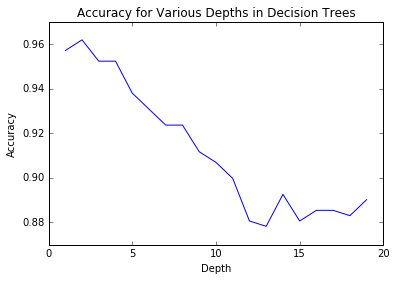

In [495]:
# tune tree for best depth
depths = range(1, 20)
kf = KFold(len(x_train), n_folds=5)
tree_score_array = []

for depth in depths:
    # use CV to optimize tree length
    for train_index, test_index in kf:
        tree_score_inner, knn_score_inner = [], []
        x_validate_train, x_validate_test = x_train[train_index], x_train[test_index]
        y_validate_train, y_validate_test = y_train[train_index], y_train[test_index]
        
        tree = DecisionTree(max_depth=depth)
        tree.fit(x_validate_train, y_validate_train)
        tree_score_inner.append(tree.score(x_validate_test, y_validate_test))
        
    tree_score_array.append(np.mean(tree_score_inner))

# determine maximum tree value and index
tree_score_max = np.max(tree_score_array)
tree_best_depth = np.argmax(tree_score_array) + 1

# plot and label axes
plt.plot(depths, tree_score_array)
plt.title("Accuracy for Various Depths in Decision Trees")
plt.xlabel("Depth")
plt.ylabel("Accuracy")

print 'Best depth: {} Accuracy: {}'.format(tree_best_depth, tree_score_max)

Best number of neighbors: 10 Accuracy: 0.941550190597


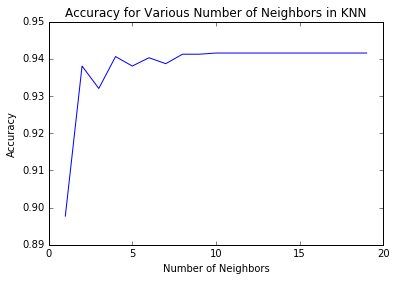

In [496]:
# tune knn for best number of neighbors
depths = range(1, 20)
knn_score_array = []

for depth in depths:
    # fit knn and score
    knn = KNN(n_neighbors=depth)
    knn.fit(x_train, y_train)
    knn_score = knn.score(x_test, y_test)
    knn_score_array.append(knn_score)

# calculate accuracy and plot
knn_score_max = np.max(knn_score_array)
knn_best_depth = np.argmax(knn_score_array) + 1
plt.plot(depths, knn_score_array)
plt.title("Accuracy for Various Number of Neighbors in KNN")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")

print 'Best number of neighbors: {} Accuracy: {}'.format(knn_best_depth, knn_score_max)

In [497]:
#KNN
knn = KNN(n_neighbors=knn_best_depth)
knn.fit(x_train, y_train)
knn_scores = score(knn, x_test, y_test)

#Unweighted logistic regression
unweighted_logistic = LogisticRegression()
unweighted_logistic.fit(x_train, y_train)
unweighted_log_scores = score(unweighted_logistic, x_test, y_test)

#Unweighted logistic quadratic regression
unweighted_logistic_poly = LogisticRegression()

#Expand our predictor array with quadratic terms
quad_features = preprocessing.PolynomialFeatures(degree = 2)
x_expanded_train = quad_features.fit_transform(x_train)
x_expanded_test = quad_features.fit_transform(x_test)

unweighted_logistic_poly.fit(x_expanded_train, y_train)
unweighted_log_poly_scores = score(unweighted_logistic_poly, x_expanded_test, y_test)

#Weighted logistic regression
weighted_logistic = LogisticRegression(class_weight='balanced')
weighted_logistic.fit(x_train, y_train)
weighted_log_scores = score(weighted_logistic, x_test, y_test)

#Weighted quad logistic regression
weighted_logistic_poly = LogisticRegression(class_weight='balanced')
#Expand our predictor array with quadratic terms
quad_features = preprocessing.PolynomialFeatures(degree = 2)
x_expanded_train = quad_features.fit_transform(x_train)
x_expanded_test = quad_features.fit_transform(x_test)

weighted_logistic_poly.fit(x_expanded_train, y_train)
weighted_log_poly_scores = score(weighted_logistic_poly, x_expanded_test, y_test)

#LDA
lda = LDA()
lda.fit(x_train, y_train)
lda_scores = score(lda, x_test, y_test)

#QDA
qda = QDA()
qda.fit(x_train, y_train)
qda_scores = score(qda, x_test, y_test)

#Decision Tree
tree = DecisionTree(max_depth=tree_best_depth)
tree.fit(x_train, y_train)
tree_scores = score(tree, x_test, y_test)

#Random Forest
rf = RandomForest()
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)

#SVM
svm = SVC(C=svm_best_depth, kernel='linear', class_weight='balanced')
svm.fit(x_train[1:100], y_train[1:100])
svm_scores = score(svm, x_test, y_test)

In [498]:
#Score Dataframe
score_df = pd.DataFrame({'knn': knn_scores, 
                         'unweighted logistic': unweighted_log_scores,
                         'unweighted quad logistic': unweighted_log_poly_scores,
                         'weighted logistic': weighted_log_scores,
                         'weighted quad logistic': weighted_log_poly_scores,
                         'lda': lda_scores,
                         'qda': qda_scores,
                         'tree': tree_scores,
                         'rf': rf_scores,
                         'weighted svm': svm_scores})
score_df

,knn,lda,qda,rf,tree,unweighted logistic,unweighted quad logistic,weighted logistic,weighted quad logistic,weighted svm
overall accuracy,0.94155,0.938374,0.839581,0.942186,0.944727,0.940915,0.939644,0.739517,0.696633,0.825921
accuracy on class 0,1.00000,0.983131,0.874494,0.997638,0.997638,0.997301,0.997976,0.749663,0.705466,0.870445
accuracy on class 1,0.00000,0.217391,0.277174,0.048913,0.092391,0.032609,0.000000,0.576087,0.554348,0.108696


In [507]:
def flu_predict(x_test):
    weighted_logistic = LogisticRegression(class_weight='balanced')
    weighted_logistic.fit(x, y)
    y_pred = weighted_logistic.predict(x_test)
    return y_pred

In [508]:
# reshape y predicted values
y_pred = flu_predict(x_testing) 
y_pred = y_pred.reshape(-1,1)
y_pred.shape

(1533, 1)

In [503]:
# reshape ID column
data_test_id = data_test_id.as_matrix().reshape(-1,1)
data_test_id.shape

(1533, 1)

In [504]:
# concatenate ID and y predicted together
data_test_full = np.concatenate([data_test_id, y_pred], axis = 1)

In [505]:
# save dataset as csv
np.savetxt(
    'flu.txt',              # file name
    data_test_full,         # array to save
    fmt='%.0f',             # formatting, 2 digits in this case
    delimiter=',',          # column delimiter
    newline='\n',           # new line character
    header = ("index,label")
)

# Part II: Diagnosing Strains of the Semian Flu

From a public health perspective, we want to balance the cost of vaccinations, early interventions and the cost of treating flu complications of unvaccinated people. 

There are two different strains of the flu: strain 1 has a cheaper early intervention as well as a cheaper treatment for flu complications, but patients with strain 1 has a higher rate of developing complications if treated with the wrong intervention. Strain 2 has a more expensive early intervention as well as a more costly treatment for flu complications, but patients with strain 2 has a lower rate of developing complications if treated with the wrong intervention. With no intervention, flu patients develop complications at the same rate regardless of the strain. 

**Your task:** build a model to predict if a given patient has the flu and identify the flu strain. The state government of MA will use your model to inform public health policies: we will vaccinate people you've identified as healthy and apply corresponding interventions to patients with different strains of the flu. We have provided you with a function to compute the total expected cost of this policy decision that takes into account the cost of the vaccine, the interventions and the cost of the treatments for flu complications resulting from misdiagnosing patients. Your goal is to make sure your model produces a public health policy with the lowest associated expected cost.

**The deliverable:** a function called `flu_predict` which satisfies:

- input: `x_test`, a set of medical predictors for a group of patients
- output: `y_pred`, a set of labels, one for each patient; 1 for healthy, 2 for infected with strain 1, and 3 for infected with strain 2.

The MA state government will use your model to diagnose sets of future patients (held by us). You can expect that there will be an increase in the number of flu patients in any groups of patients in the future.

We provide you with some benchmarks for comparison.

**Three Baseline Models:** 
- expected cost on observed data: \$6,818,206.0, \$7,035,735.0, \$8,297,197.5
- time to build: 1 min

**Reasonable Model:** 
- expected cost on observed data: $6,300,000
- time to build: 20 min

**Grading:**
Your grade will be based on:
1. your model's ability to out-perform our benchmarks
2. your ability to carefully and thoroughly follow the data science pipeline (see lecture slides for definition)
3. the extend to which all choices are reasonable and defensible by methods you have learned in this class

---

We want to predict not only the presence of the flu but also the strain of flu (strain 1 or strain 2). We can measure effectivness using the cost function, which outputs the cost. I applied the same cleaning methods from part 1 to the dataset and split into testing and training sets.

I test 4 random models:
1. Assume all 1 - healthy
2. Assume all 2 - infected with strain 1
3. Assume all 3 - infected with strain 2
4. (Bonus) Randomly assign a value - either 1, 2, or 3 all with equal likelihood 

The cost is much lower for all 1s (all healthy) than for assuming all 2/3s or random. This is because we need to consider the drastically increased number of false positive and incorect diagnoses. 

I tuned random forests for the optimal depth to establish a baseline. The next step is to test on 10 different models.
1. KNN
2. Unweighted logistic regression
3. Unweighted logistic quadratic regression
4. Weighted logistic regression
5. Weighted quad logistic regression
6. LDA
7. QDA
8. Decision Tree
9. Random Forest
10. SVM

LDA produced the lowest costs out of all models. However, LDA assumes normally distributed predictor values, which is not the case with our data. Roughly half of our data consists of categorical variables transformed through one-hot and is therefore not guassian distributed. Thus, I am more inclined to believe that the lower costs are attributed to chance and cannot be reliablely replicated. Random forests and decision trees have very similiar costs ($6.3 million). However, random forests are generally more accurate than decision trees, especially after tuning, so I decided to proceed with this model. Random forests allows for the most accurate divisions and combines multiple trees, which allow us to reduce variance through averaging out multiple trials. It also has fairly high predictive accuracy among all three classes.

The next step is to tune the depth of the random forest according to costs. By finding the minimum of the plot, we have the depth of the tree that results in the classification with the lowest cost. I used the tuned random forest to produce my final estimates (costs of $5907996.0).

Finally, I concatenated IDs and final predictions together to export into CSV format.  

In [782]:
#--------  cost
# A function that computes the expected cost of the public healthy policy based on the 
# classifications generated by your model
# Input: 
#      y_true (true class labels: 1, 2, 3)
#      y_pred (predicted class labels: 1, 2, 3)
# Returns: 
#      total_cost (expected total cost)

def cost(y_true, y_pred):
    cost_of_treatment_1 = 29500
    cost_of_treatment_2 = 45000
    cost_of_intervention_1 = 4150
    cost_of_intervention_2 = 4250
    cost_of_vaccine = 15
    
    prob_complications_untreated = 0.65
    prob_complications_1 = 0.30
    prob_complications_2 = 0.15
    
    trials = 1000
    
    intervention_cost = cost_of_intervention_1 * len(y_pred[y_pred==2]) + cost_of_intervention_2 * len(y_pred[y_pred==3])

    vaccine_cost = cost_of_vaccine * len(y_pred[y_pred==1])
    
    false_neg_1 = ((y_true == 2) & (y_pred == 3)).sum()
    false_neg_2 = ((y_true == 3) & (y_pred == 2)).sum()
    
    untreated_1 = ((y_true == 2) & (y_pred == 1)).sum()    
    untreated_2 = ((y_true == 3) & (y_pred == 1)).sum()
    
    false_neg_1_cost = np.random.binomial(1, prob_complications_1, (false_neg_1, trials)) * cost_of_treatment_1
    false_neg_2_cost = np.random.binomial(1, prob_complications_2, (false_neg_2, trials)) * cost_of_treatment_2
    untreated_1_cost = np.random.binomial(1, prob_complications_untreated, (untreated_1, trials)) * cost_of_treatment_1
    untreated_2_cost = np.random.binomial(1, prob_complications_untreated, (untreated_2, trials)) * cost_of_treatment_2
    
    false_neg_1_cost = false_neg_1_cost.sum(axis=0)
    expected_false_neg_1_cost = false_neg_1_cost.mean()
    
    false_neg_2_cost = false_neg_2_cost.sum(axis=0)
    expected_false_neg_2_cost = false_neg_2_cost.mean()
    
    untreated_1_cost = untreated_1_cost.sum(axis=0)
    expected_untreated_1_cost = untreated_1_cost.mean()
    
    untreated_2_cost = untreated_2_cost.sum(axis=0)
    expected_untreated_2_cost = untreated_2_cost.mean()
    
    total_cost = vaccine_cost + intervention_cost + expected_false_neg_1_cost + expected_false_neg_2_cost + expected_untreated_1_cost + expected_untreated_2_cost
    
    return total_cost

In [783]:
# separate out x and y values
x = data_train.values[:, :-2]
y = data_train.values[:, -1]

# Apply one hot endcoing
encoder = preprocessing.OneHotEncoder(categorical_features=categorical[:-2], sparse=False)  # Last value in mask is y
x = encoder.fit_transform(x)

x_testing = data_test.values
encoder = preprocessing.OneHotEncoder(categorical_features=categorical, sparse=False)  # Last value in mask is y
x_testing = encoder.fit_transform(x_testing)
data_test.head(n=5)

,Gender,Age,Race1,Education,MaritalStatus,HHIncomeMid,Poverty,HomeRooms,HomeOwn,Work,...,PhysActive,Alcohol12PlusYr,AlcoholYear,Smoke100,Smoke100n,HardDrugs,SexEver,SexAge,SexNumPartnLife,SameSex
0,1,4.0,4,4,2,22500.0,1.07,9.0,1,2,...,1,1,24.0,0,0,0,1,17.0,5.0,0
1,1,60.0,5,3,2,17500.0,1.03,5.0,1,2,...,0,1,36.0,1,1,0,1,20.0,1.0,0
2,1,38.0,5,4,2,22500.0,1.15,6.0,1,2,...,0,0,0.0,0,0,0,1,23.0,1.0,0
3,1,8.0,5,4,2,70000.0,3.55,5.0,1,2,...,1,1,24.0,0,0,0,1,17.0,5.0,0
4,0,59.0,4,0,5,22500.0,1.37,4.0,2,1,...,0,1,24.0,0,0,0,1,17.0,5.0,0


In [784]:
# split dataset into testing and training sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.6, random_state=42)

In [785]:
# score function that plugs values into cost function
score = lambda model, x_test, y_test: pd.Series([cost(y_test, model.predict(x_test)),
                                                 model.score(x_test[y_test==1], y_test[y_test==1]),
                                                 model.score(x_test[y_test==2], y_test[y_test==2]),
                                                 model.score(x_test[y_test==3], y_test[y_test==3])], 
                                                 index=['overall cost', 'class 1', 'class 2', 'class 3'])

In [786]:
# predicts all class 1
class One_model(object):
    def predict(self, x):
        return np.array([1] * len(x))
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)
    
#A model that labels everything 2
class Two_model(object):
    def predict(self, x):
        return np.array([2] * len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)
    
# A model that labels everything 3
class Three_model(object):
    def predict(self, x):
        return np.array([3] * len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)

#A model that randomly labels things
class Random_model(object):
    def predict(self, x):
        return np.random.randint(1, 4, len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)

In [787]:
# run all of our models and score to obtain costs
one_model = One_model()
one_model_scores = score(one_model, x, y)

two_model = Two_model()
two_model_scores = score(two_model, x, y)

three_model = Three_model()
three_model_scores = score(three_model, x, y)

random_model = Random_model()
random_model_scores = score(random_model, x, y)

In [788]:
#cost Dataframe
score_df = pd.DataFrame({'random model': random_model_scores,
                         'one model': one_model_scores,
                         'two model': two_model_scores,
                         'three model': three_model_scores})
score_df

,one model,random model,three model,two model
overall cost,6858961.0,1.771844e+07,24314745.5,22329350.0
class 1,1.0,3.375203e-01,0.0,0.0
class 2,0.0,3.480176e-01,0.0,1.0
class 3,0.0,3.734940e-01,1.0,0.0


In [789]:
# optimize accuracy by comparing predictors through a grid search
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)

    best = gs.best_estimator_
    return best

# find best parameters by optimizing parameters before finding accuracy   
def do_classify(clf, parameters, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    if parameters:
        clf = cv_optimize(clf, parameters, x_train, y_train, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(x_train, y_train)
    
    # calculate training and testing accuracy to print
    training_accuracy = clf.score(x_train, y_train)
    test_accuracy = clf.score(x_test, y_test)
    print "############# based on optimization ################"
    print "Accuracy on training data: %f" % (training_accuracy)
    print "Accuracy on test data:     %f" % (test_accuracy)
    print confusion_matrix(y_test, clf.predict(x_test))
    print "########################################################"
    return clf, x_train, y_train, x_test, y_test

In [818]:
# initalize random forest classifer
clfForest = RandomForestClassifier(oob_score=True, max_features = 'auto')

# FIT THE TREE 
clf=clfForest.fit(x_train[1:100], y_train[1:100])

# calculate training and testing accuracy to print
training_accuracy = clfForest.score(x_train, y_train)
test_accuracy = clfForest.score(x_test, y_test)
print "############# based on standard predict ################"
print "Accuracy on training data: %f" % (training_accuracy)
print "Accuracy on test data:     %f" % (test_accuracy)
print confusion_matrix(y_test, clf.predict(x_test))
print "########################################################"

# print parameters selected or default
print 'Number of Trees before Optimization: ', clfForest.n_estimators
print 'Depth before Optimization: ', clfForest.max_depth

############# based on standard predict ################
Accuracy on training data: 0.940419
Accuracy on test data:     0.941550
[[2964    0    0]
 [ 138    0    0]
 [  46    0    0]]
########################################################
Number of Trees before Optimization:  10
Depth before Optimization:  None


In [819]:
# test parameters: the number of trees, depth of each tree
parameters = {"n_estimators": range(1,20), "max_depth": range(1,10)}

clfForest, x_train, y_train, x_test, y_test = do_classify(clfForest, parameters, 
                                                       n_jobs = 4)

# print optimized parameters selected
print 'Number of trees: ', clfForest.n_estimators
print 'Optimized Tree Depth: ', clfForest.max_depth

############# based on optimization ################
Accuracy on training data: 0.953289
Accuracy on test data:     0.941550
[[2963    1    0]
 [ 135    1    2]
 [  46    0    0]]
########################################################
Number of trees:  18
Optimized Tree Depth:  7


In [820]:
#KNN
knn = KNN(n_neighbors=knn_best_depth)
knn.fit(x_train, y_train)
knn_cost = score(knn, x, y)

#Unweighted logistic regression
unweighted_logistic = LogisticRegression()
unweighted_logistic.fit(x_train, y_train)
unweighted_log_cost = score(unweighted_logistic, x, y)

#Unweighted logistic quadratic regression
unweighted_logistic_poly = LogisticRegression()

#Expand our predictor array with quadratic terms
quad_features = preprocessing.PolynomialFeatures(degree = 2)
x_expanded_train = quad_features.fit_transform(x_train)
x_expanded_test = quad_features.fit_transform(x)

unweighted_logistic_poly.fit(x_expanded_train, y_train)
unweighted_log_poly_cost = score(unweighted_logistic_poly, x_expanded_test, y)

#Weighted logistic regression
weighted_logistic = LogisticRegression(class_weight='balanced', C = logreg_best_depth)
weighted_logistic.fit(x_train, y_train)
weighted_log_cost = score(weighted_logistic, x, y)

#Weighted quad logistic regression
weighted_logistic_poly = LogisticRegression(class_weight='balanced')
#Expand our predictor array with quadratic terms
quad_features = preprocessing.PolynomialFeatures(degree = 2)
x_expanded_train = quad_features.fit_transform(x_train)
x_expanded_test = quad_features.fit_transform(x)

weighted_logistic_poly.fit(x_expanded_train, y_train)
weighted_log_poly_cost = score(weighted_logistic_poly, x_expanded_test, y)

#LDA
lda = LDA()
lda.fit(x_train, y_train)
lda_cost = score(lda, x, y)

#QDA
qda = QDA()
qda.fit(x_train, y_train)
qda_cost = score(qda, x, y)

#Decision Tree
tree = DecisionTree(max_depth=tree_best_depth)
tree.fit(x_train, y_train)
tree_cost = score(tree, x, y)

#Random Forest
clfForest.fit(x_train, y_train)
rf_cost = score(clfForest, x, y)

#SVM
svm = SVC(C=svm_best_depth, kernel='linear', class_weight='balanced')
svm.fit(x_train[1:100], y_train[1:100])
svm_cost = score(svm, x, y)

In [821]:
#Score Dataframe
score_df = pd.DataFrame({'knn': knn_cost, 
                         'unweighted logistic': unweighted_log_cost,
                         'unweighted quad logistic': unweighted_log_poly_cost,
                         'weighted logistic': weighted_log_cost,
                         'weighted quad logistic': weighted_log_poly_cost,
                         'lda': lda_cost,
                         'qda': qda_cost,
                         'tree': tree_cost,
                         'rf': rf_cost,
                         'weighted svm': svm_cost})
score_df

,knn,lda,qda,rf,tree,unweighted logistic,unweighted quad logistic,weighted logistic,weighted quad logistic,weighted svm
overall cost,6859791.5,6.015724e+06,7.040768e+06,6.308096e+06,6.317422e+06,6.763164e+06,6.876390e+06,6.366764e+06,6.520899e+06,8.011370e+06
class 1,1.0,9.841977e-01,9.072123e-01,1.000000e+00,9.979741e-01,9.979741e-01,9.987844e-01,9.629254e-01,9.673825e-01,9.371961e-01
class 2,0.0,5.726872e-02,4.449339e-01,8.810573e-02,8.370044e-02,8.810573e-03,0.000000e+00,9.251101e-02,6.167401e-02,1.762115e-02
class 3,0.0,3.493976e-01,0.000000e+00,1.204819e-01,0.000000e+00,3.614458e-02,0.000000e+00,3.614458e-01,3.373494e-01,1.204819e-02


Best depth: 5


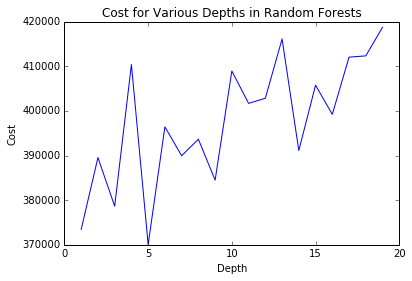

In [810]:
# tune tree for optimal depth
depths = range(1, 20)
kf = KFold(len(x_train), n_folds=5)
cost_array = []

for depth in depths:
    validation_cost = []
    # use CV to reduce variance
    for train_index, test_index in kf:
        x_validate_train, x_validate_test = x_train[train_index], x_train[test_index]
        y_validate_train, y_validate_test = y_train[train_index], y_train[test_index]
        
        clfForest.fit(x_train, y_train)
        y_pred = clfForest.predict(x_validate_test)
        validation_cost.append(cost(y_validate_test, y_pred))
        
    cost_array.append(np.mean(validation_cost))

# determine optimal tree depth and accuracy
best_depth = np.argmin(cost_array) + 1
min_cost = np.amin(cost_array)

# plot and label axes
plt.plot(depths, cost_array)
plt.title("Cost for Various Depths in Random Forests")
plt.xlabel("Depth")
plt.ylabel("Cost")

print 'Best depth: {}'.format(best_depth)

In [811]:
# produce deliverable function flu_preidct
def flu_predict(x_test):
    tree = DecisionTree(max_depth = best_depth)
    tree.fit(x, y)
    y_pred = tree.predict(x_test)
    return y_pred

In [812]:
# prediction to find new cost metric
final_cost = cost(y, flu_predict(x))
print 'Final Cost after Tuning: ', final_cost

Final Cost after Tuning:  5907996.0


In [813]:
# generate y_pred on full testing set
y_pred = flu_predict(x_testing) 

In [824]:
# reshape y_pred into column vector
y_pred = y_pred.reshape(-1,1)
y_pred.shape

(1533, 1)

In [825]:
# concatenate id and y_pred together
data_test_full_2 = np.concatenate([data_test_id, y_pred], axis = 1)

In [828]:
# save results as a csv
np.savetxt(
    'flu_part_2.txt',           # file name
    data_test_full_2,                # array to save
    fmt='%.0f',             # formatting, 2 digits in this case
    delimiter=',',          # column delimiter
    newline='\n',           # new line character
    header = ("index,label")
)